# Dataset
Penjelasan Label 
* 0: sms normal 
* 1: fraud atau penipuan 
* 2: promo

## Laod Data

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd

data = pd.read_csv('data/dataset_sms_spam_v1.csv')
data.head() 

,teks,label
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2


## Preview Data

Total Jumlah SMS: 1143 data

terdiri dari (label):
-- [0] SMS Normal	: 569 data
-- [1] Fraud / Penipuan	: 335 data
-- [2] Promo		: 239 data



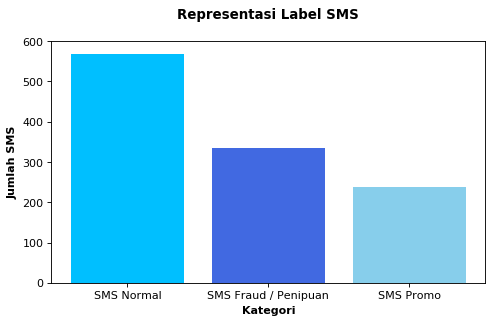

In [3]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

print('Total Jumlah SMS:', data.shape[0], 'data\n')
print('terdiri dari (label):')
print('-- [0] SMS Normal\t:', data[data.label == 0].shape[0], 'data')
print('-- [1] Fraud / Penipuan\t:', data[data.label == 1].shape[0], 'data')
print('-- [2] Promo\t\t:', data[data.label == 2].shape[0], 'data\n')

height = data['label'].value_counts()
labels = ('SMS Normal', 'SMS Fraud / Penipuan', 'SMS Promo')
y_pos = np.arange(len(labels))

plt.figure(figsize=(7,4), dpi=80)
plt.ylim(0,600)
plt.title('Representasi Label SMS\n', fontweight='bold')
plt.xlabel('Kategori', fontweight='bold')
plt.ylabel('Jumlah SMS', fontweight='bold')
plt.bar(y_pos, height, color=['deepskyblue', 'royalblue', 'skyblue'])
plt.xticks(y_pos, labels)

plt.savefig('img/representasi label.png') # save plot

# Preprocessing
## Case Folding

In [4]:
import re

def casefolding(text):
    text = text.lower() # merubah bentuk menjadi lower case
    text = re.sub(r'\d+', '', text) # menghapus angka
    text = re.sub(r'[^\w\s]','',text) # menghapus karakter tanda baca
    text = text.strip()
    return text

In [5]:
key_norm = pd.read_csv('data/key_norm.csv')

def text_normalize(text):
    text = ' '.join([key_norm[key_norm['singkat'] == word]['hasil'].values[0] if (key_norm["singkat"] == word).any() else word for word in text.split()])
    text = str.lower(text)
    return text

## Filtering (Stopword Removal)

In [6]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

stop_factory = stopwords.words('indonesian')
more_stopword = ['daring', 'online', 'pd']

def remove_stop_words(text):
    sw = stop_factory + more_stopword
    clean_words = []
    text = text.split()
    for word in text:
        if word not in sw:
            clean_words.append(word)
    return " ".join(clean_words)

## Stemming

In [7]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemming(text):
    text = stemmer.stem(text)
    return text

# Text Preprocessing Pipeline

In [8]:
def data_process(text):
    text = casefolding(text)
    text = text_normalize(text)
    text = remove_stop_words(text)
    text = stemming(text)
    return text

In [9]:
import time

t1 = time.time()
data['teks'] = data['teks'].apply(data_process)
print('cleaning dataset elapsed time:', time.time() - t1, '\n')

cleaning dataset elapsed time: 18.66572093963623 



In [10]:
data.to_csv('data/clean_data.csv', encoding='utf-8')

In [11]:
data.head()

,teks,label
0,promo beli paket flash gb my telkomsel app ext...,2
1,gb rupiah ribu spesial pilih aktif promo sd no...,2
2,pulang hormat sisa kuota flash kb download myt...,2
3,pulang hormat sisa kuota flash kb download myt...,2
4,gb rupiah ribu spesial pilih aktif buru skb,2


## Highest word frequencies in each class

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()
words_count_matrix = cv.fit_transform(data['teks'])
count_vect = pd.SparseDataFrame(words_count_matrix, columns=cv.get_feature_names())

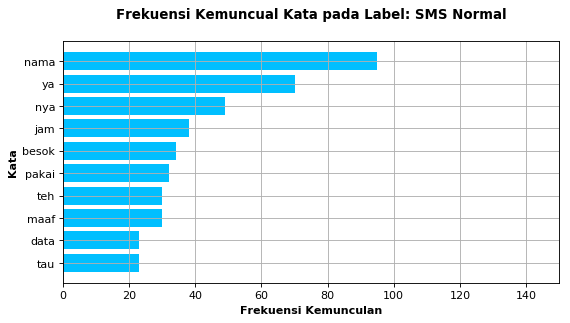

In [13]:
# SMS Normal
normal_words = count_vect[data.label == 0]
normal_words_count = normal_words.sum()
indices = np.argsort(normal_words_count)[::-1][:10]
normal_words_count = normal_words_count[indices]

plt.figure(figsize=(8,4), dpi=80)
plt.barh(np.arange(len(normal_words_count)),
         normal_words_count.values, 
         color='deepskyblue')
plt.yticks(np.arange(len(normal_words_count)), normal_words_count.keys())
plt.gca().invert_yaxis()
plt.xlim(0,150)
plt.title('Frekuensi Kemuncual Kata pada Label: SMS Normal\n', fontweight='bold')
plt.xlabel('Frekuensi Kemunculan', fontweight='bold')
plt.ylabel('Kata', fontweight='bold')
plt.grid()

plt.savefig('img/frekuensi_kata_normal.png') # save plot

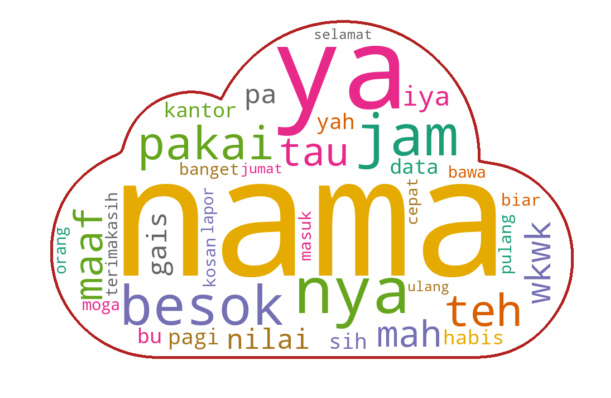

In [14]:
import cv2

originalImage = cv2.imread('img/cloud.jpg')
grayImage = cv2.cvtColor(originalImage, cv2.COLOR_BGR2GRAY)
(thresh, cloud_mask) = cv2.threshold(grayImage, 100, 255, cv2.THRESH_BINARY)

# WordCloud Label SMS Normal
sms_normal = data[data.label == 0]
normal_string = []
for t in sms_normal.teks:
    normal_string.append(t)
normal_string = pd.Series(normal_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800, margin=10,
                      background_color='white', colormap='Dark2',
                      max_font_size=300, min_font_size=25,
                      mask=cloud_mask, contour_width=5, contour_color='firebrick',
                      max_words=100).generate(normal_string)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

wordcloud.to_file("img/worcloud_normal.png")

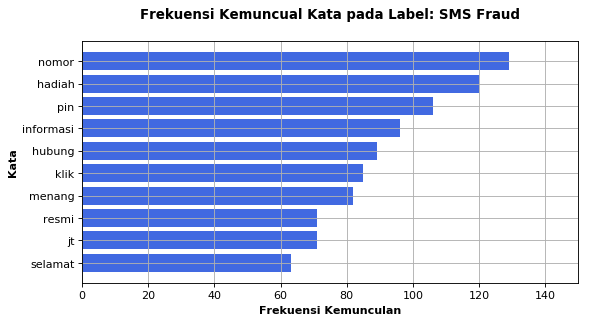

In [15]:
# SMS Fraud
fraud_words = count_vect[data.label == 1]
fraud_words_count = fraud_words.sum()
indices = np.argsort(fraud_words_count)[::-1][:10]
fraud_words_count = fraud_words_count[indices]

plt.figure(figsize=(8,4), dpi=80)
plt.barh(np.arange(len(fraud_words_count)),
         fraud_words_count.values, 
         color='royalblue')
plt.yticks(np.arange(len(fraud_words_count)), fraud_words_count.keys())
plt.gca().invert_yaxis()
plt.xlim(0,150)
plt.title('Frekuensi Kemuncual Kata pada Label: SMS Fraud\n', fontweight='bold')
plt.xlabel('Frekuensi Kemunculan', fontweight='bold')
plt.ylabel('Kata', fontweight='bold')
plt.grid()

plt.savefig('img/frekuensi_kata_fraud.png') # save plot

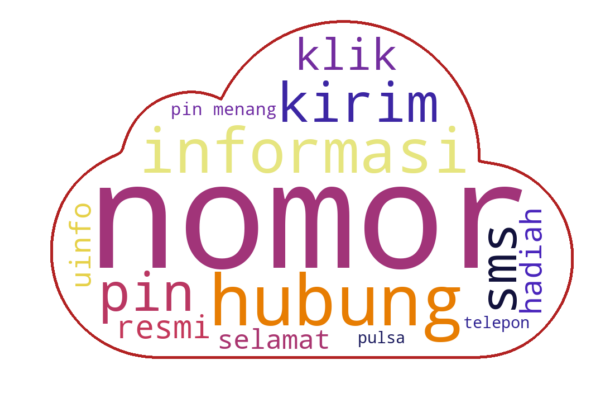

In [16]:
# WordCloud Label SMS Fraud / Penipuan
sms_fraud = data[data.label == 1]
fraud_string = []
for t in sms_fraud.teks:
    fraud_string.append(t)
fraud_string = pd.Series(fraud_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800, margin=10,
                      background_color='white', colormap='CMRmap',
                      max_font_size=300, min_font_size=25,
                      mask=cloud_mask, contour_width=5, contour_color='firebrick',
                      max_words=100).generate(fraud_string)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

wordcloud.to_file("img/worcloud_fraud.png")

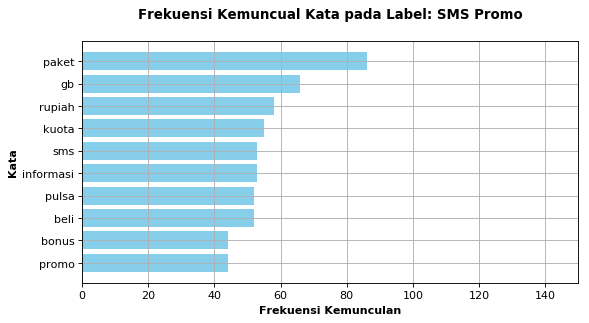

In [17]:
# SMS Promo
promo_words = count_vect[data.label == 2]
promo_words_count = promo_words.sum()
indices = np.argsort(promo_words_count)[::-1][:10]
promo_words_count = promo_words_count[indices]

plt.figure(figsize=(8,4), dpi=80)
plt.barh(np.arange(len(promo_words_count)),
         promo_words_count.values, 
         color='skyblue')
plt.yticks(np.arange(len(promo_words_count)), promo_words_count.keys())
plt.gca().invert_yaxis()
plt.xlim(0,150)
plt.title('Frekuensi Kemuncual Kata pada Label: SMS Promo\n', fontweight='bold')
plt.xlabel('Frekuensi Kemunculan', fontweight='bold')
plt.ylabel('Kata', fontweight='bold')
plt.grid()

plt.savefig('img/frekuensi_kata_promo.png') # save plot

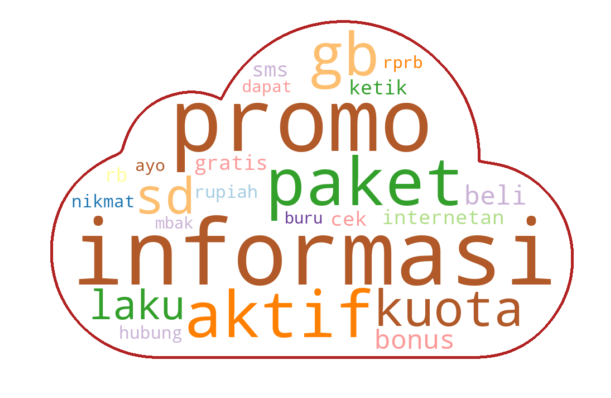

In [18]:
# WordCloud Label SMS Promo
sms_promo = data[data.label == 2]
promo_string = []
for t in sms_promo.teks:
    promo_string.append(t)
promo_string = pd.Series(promo_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800, margin=10,
                      background_color='white', colormap='Paired',
                      max_font_size=300, min_font_size=25,
                      mask=cloud_mask, contour_width=5, contour_color='firebrick',
                      max_words=100).generate(promo_string)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

wordcloud.to_file("img/worcloud_promo.png")

# Get the most and least frequent words

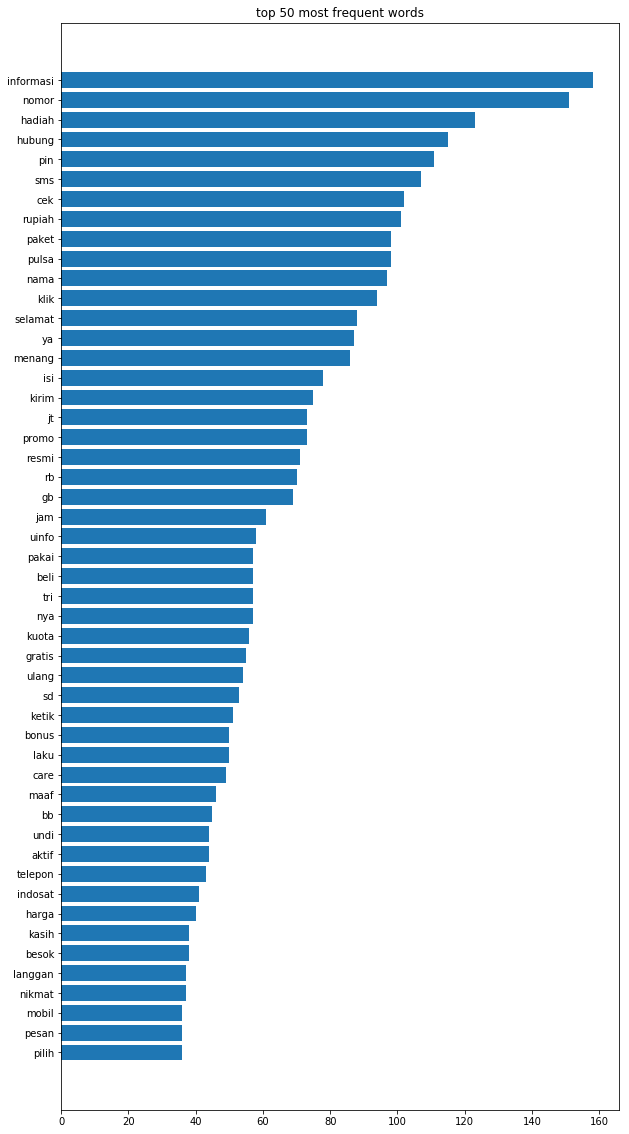

In [19]:
all_word_count = count_vect[data.label < 3].sum()
indices = np.argsort(all_word_count)[::-1][:50]
all_word_count = all_word_count[indices]

plt.figure(figsize=(10, 20))
plt.barh(np.arange(len(all_word_count)), all_word_count.values, align='edge', height=0.8)
plt.yticks(np.arange(len(all_word_count)) + 0.4, all_word_count.keys())
plt.gca().invert_yaxis()
plt.title('top 50 most frequent words')
plt.show()

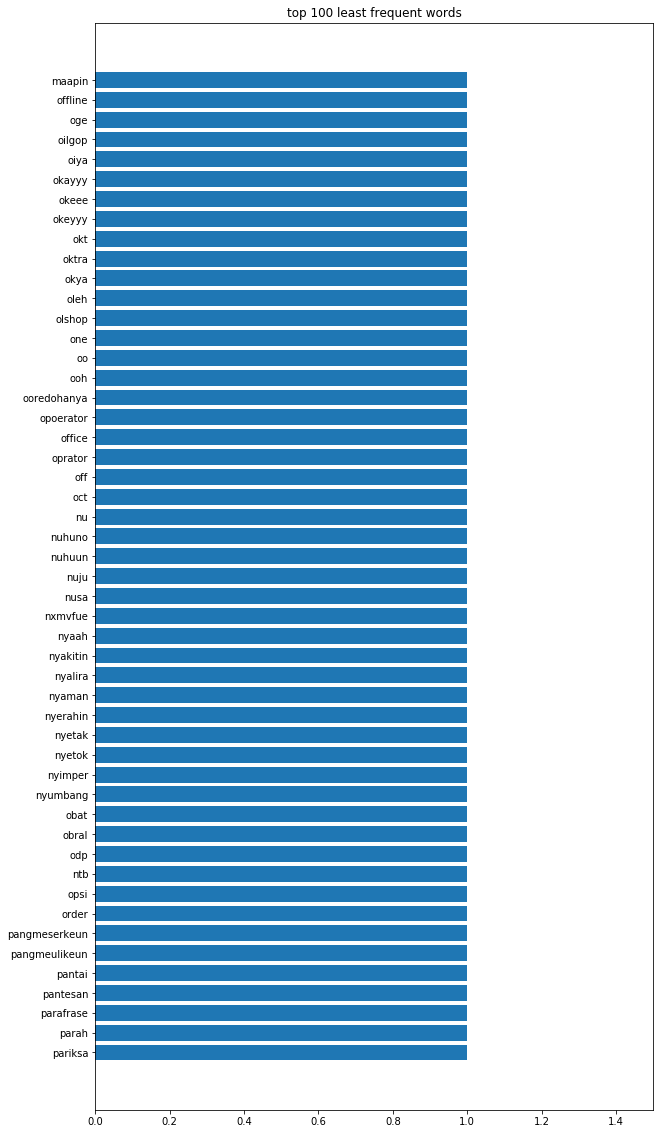

In [20]:
all_word_count = count_vect[data.label < 3].sum()
indices = np.argsort(all_word_count)[:50]
all_word_count = all_word_count[indices]

plt.figure(figsize=(10, 20))
plt.xlim(0,1.5)
plt.barh(np.arange(len(all_word_count)), all_word_count.values, align='edge', height=0.8)
plt.yticks(np.arange(len(all_word_count)) + 0.4, all_word_count.keys())
plt.gca().invert_yaxis()
plt.title('top 100 least frequent words')
plt.show()

In [21]:
all_word_count = count_vect[data.label < 3].sum()

In [22]:
too_common_words = list(filter(lambda w: all_word_count[w] > 1000, all_word_count.keys()))
common_words = list(filter(lambda w: all_word_count[w] > 75, all_word_count.keys()))
too_rare_words = list(filter(lambda w: all_word_count[w] < 20, all_word_count.keys()))

In [23]:
len(common_words)

16

In [24]:
len(too_rare_words)

3346

In [25]:
len(all_word_count.keys())

3446

# Feature Extraction

In [26]:
from sklearn.model_selection import train_test_split

X = data['teks']
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((914,), (229,), (914,), (229,))

## Bag of Words

In [27]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()
X_train_cv = cv.fit_transform(X_train)
X_train_cv.shape

(914, 2979)

## TF-IDF

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_train_tfidf.shape

(914, 2979)

## Bag of Words & TF-IDF

In [29]:
from scipy.sparse.csr import csr_matrix

In [30]:
transform_to_tfidf_cv_dataset = lambda tf, cv: csr_matrix(list(map(lambda i: [*tf[i].toarray()[0], *cv[i].toarray()[0]], [i for i in range(tf.shape[0])])))

In [31]:
X_train_tfidf_cv = transform_to_tfidf_cv_dataset(X_train_tfidf, X_train_cv)

In [32]:
X_train_tfidf_cv

<914x5958 sparse matrix of type '<class 'numpy.float64'>'
	with 18008 stored elements in Compressed Sparse Row format>

## Word Embedding: Word2Vec

In [33]:
import gensim
from functools import reduce

In [34]:
EMBEDDING_SIZE = 10

In [35]:
model = gensim.models.Word2Vec(list(map(lambda s: s.split(), X)), min_count=1,  size=EMBEDDING_SIZE)

In [36]:
model.wv.most_similar('promo')

[('sayabpk', 0.9048938155174255),
 ('paham', 0.8457876443862915),
 ('point', 0.8423632383346558),
 ('reski', 0.8295268416404724),
 ('lanjutin', 0.8284118175506592),
 ('dtng', 0.8227097392082214),
 ('aktif', 0.8149037957191467),
 ('kuota', 0.8129925727844238),
 ('november', 0.8089087009429932),
 ('resto', 0.7872388362884521)]

In [37]:
sentence_embedding = lambda s: reduce(
        lambda v1, v2: v1 + v2, 
        list(
            map(
                model.wv.get_vector,
                [w for w in set(s.split()) if w not in too_common_words and w not in too_rare_words]
            )
        ),
        np.zeros(EMBEDDING_SIZE)
    )

In [38]:
transform_to_embedding_dataset = lambda dataset: np.array(list(map(sentence_embedding, dataset)))

In [39]:
X_train_embedding = transform_to_embedding_dataset(X_train)

# Word Embedding combined with others

In [40]:
FW_EMBEDDING_SIZE = 100
CONTEXT_WINDOW = 3

In [41]:
fw_model = gensim.models.Word2Vec(list(map(lambda s: s.split(), X)), min_count=1, window=CONTEXT_WINDOW, size=FW_EMBEDDING_SIZE)

In [42]:
def fw_sentence_embedding(s):
    current = np.zeros(FW_EMBEDDING_SIZE)
    words = s.split()
    fw = [w for w in words if w in too_common_words][:3]
    fw = [*fw, *[w for w in words if w in common_words]][:3]
    if len(fw) > 0:
        for target in fw:
            t = words.index(target)
            for i in range(1, CONTEXT_WINDOW+1):
                if t-i < 0:
                    break
                current += fw_model.wv.get_vector(words[t-i])
            for i in range(1, CONTEXT_WINDOW+1):
                if t+i >= len(words):
                    break
                current += fw_model.wv.get_vector(words[t+i])
    return current

In [43]:
transform_to_fw_embedding_dataset = lambda dataset: np.array(list(map(fw_sentence_embedding, dataset)))

In [44]:
X_train_fw_embedding = transform_to_fw_embedding_dataset(X_train)

In [45]:
transform_to_embedding_cv_dataset = lambda embedding, cv: csr_matrix(list(map(lambda i: [*embedding[i], *cv[i].toarray()[0]], [i for i in range(len(embedding))])))

In [46]:
transform_to_embedding_tfidf_dataset = transform_to_embedding_cv_dataset

In [47]:
transform_to_embedding_tfidf_cv_dataset = lambda embedding, tfidf, cv: csr_matrix(list(map(lambda i: [*embedding[i], *tfidf[i].toarray()[0], *cv[i].toarray()[0]], [i for i in range(len(embedding))])))

In [48]:
X_train_embedding_cv = transform_to_embedding_cv_dataset(X_train_fw_embedding, X_train_cv)

In [49]:
X_train_embedding_tfidf = transform_to_embedding_tfidf_dataset(X_train_fw_embedding, X_train_tfidf)

In [50]:
X_train_embedding_tfidf_cv = transform_to_embedding_tfidf_cv_dataset(X_train_fw_embedding, X_train_tfidf, X_train_cv)

# Model Evaluation

In [51]:
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

In [52]:
def print_report(report):
    print('\t\t\tPrecision\tRecall\t\tF1-Score')
    print('SMS Normal\t\t{:.4f}\t\t{:.4f}\t\t{:.4f}'.format(report['SMS Normal']['precision'], report['SMS Normal']['recall'], report['SMS Normal']['f1-score']))
    print('SMS Fraud / Penipuan\t{:.4f}\t\t{:.4f}\t\t{:.4f}'.format(report['SMS Fraud / Penipuan']['precision'], report['SMS Fraud / Penipuan']['recall'], report['SMS Fraud / Penipuan']['f1-score']))
    print('SMS Promo\t\t{:.4f}\t\t{:.4f}\t\t{:.4f}'.format(report['SMS Promo']['precision'], report['SMS Promo']['recall'], report['SMS Promo']['f1-score']))
    print('Weighted Average:\t{:.4f}\t\t{:.4f}\t\t{:.4f}'.format(
        ((report['SMS Normal']['precision'] * report['SMS Normal']['support']) + (report['SMS Fraud / Penipuan']['precision'] * report['SMS Fraud / Penipuan']['support']) + (report['SMS Promo']['precision'] * report['SMS Promo']['support']))/(report['SMS Normal']['support'] + report['SMS Fraud / Penipuan']['support'] + report['SMS Promo']['support']),
        ((report['SMS Normal']['recall'] * report['SMS Normal']['support']) + (report['SMS Fraud / Penipuan']['recall'] * report['SMS Fraud / Penipuan']['support']) + (report['SMS Promo']['recall'] * report['SMS Promo']['support']))/(report['SMS Normal']['support'] + report['SMS Fraud / Penipuan']['support'] + report['SMS Promo']['support']),
        ((report['SMS Normal']['f1-score'] * report['SMS Normal']['support']) + (report['SMS Fraud / Penipuan']['f1-score'] * report['SMS Fraud / Penipuan']['support']) + (report['SMS Promo']['f1-score'] * report['SMS Promo']['support']))/(report['SMS Normal']['support'] + report['SMS Fraud / Penipuan']['support'] + report['SMS Promo']['support']),
    ))
    print('-----------------------------------------------------------------')

In [53]:
def print_param(param):
    print('Best parameters\n')
    for p in param:
        print(p, ':', param[p])
    print('=================================================================\n\n')

In [54]:
from timeit import default_timer as timer

def evaluate_cv(clf, name, param):
    t1 = timer()
    clf = GridSearchCV(clf, param, cv=5, n_jobs=7)
    clf.fit(X_train_cv, y_train)
    print('=================================================================')
    print(name, 'with Bag of Words\n')
    print_report(classification_report(y_test, 
                                       clf.predict(cv.transform(X_test)), 
                                       target_names=['SMS Normal', 'SMS Fraud / Penipuan', 'SMS Promo'], 
                                       output_dict=True))
    print('Elapsed time:', timer() - t1, 'seconds')
    print('-----------------------------------------------------------------')
    print_param(clf.best_params_)

In [55]:
def evaluate_tfidf(clf, name, param):
    t1 = timer()
    clf = GridSearchCV(clf, param, cv=5, n_jobs=7)
    clf.fit(X_train_tfidf, y_train)
    print('=================================================================')
    print(name, 'with TF-IDF\n')
    print_report(classification_report(y_test, 
                                       clf.predict(tfidf.transform(X_test)), 
                                       target_names=['SMS Normal', 'SMS Fraud / Penipuan', 'SMS Promo'], 
                                       output_dict=True))
    print('Elapsed time:', timer() - t1, 'seconds')
    print('-----------------------------------------------------------------')
    print_param(clf.best_params_)

In [56]:
def evaluate_word_embedding(clf, name, param):
    t1 = timer()
    clf = GridSearchCV(clf, param, cv=5, n_jobs=7)
    clf.fit(X_train_embedding, y_train)
    print('=================================================================')
    print(name, 'with Word Embedding\n')
    print_report(classification_report(y_test, 
                                       clf.predict(transform_to_embedding_dataset(X_test)), 
                                       target_names=['SMS Normal', 'SMS Fraud / Penipuan', 'SMS Promo'], 
                                       output_dict=True))
    print('Elapsed time:', timer() - t1, 'seconds')
    print('-----------------------------------------------------------------')
    print_param(clf.best_params_)

In [57]:
def evaluate_word_embedding_cv(clf, name, param):
    t1 = timer()
    clf = GridSearchCV(clf, param, cv=5, n_jobs=7)
    clf.fit(X_train_embedding_cv, y_train)
    print('=================================================================')
    print(name, 'with Word Embedding and Bag of Words\n')
    print_report(classification_report(
        y_test,
        clf.predict(
            transform_to_embedding_cv_dataset(
                transform_to_fw_embedding_dataset(X_test),
                cv.transform(X_test)
            )
        ),
        target_names=['SMS Normal', 'SMS Fraud / Penipuan', 'SMS Promo'],
        output_dict=True
    ))
    print('Elapsed time:', timer() - t1, 'seconds')
    print('-----------------------------------------------------------------')
    print_param(clf.best_params_)

In [58]:
def evaluate_word_embedding_tfidf(clf, name, param):
    t1 = timer()
    clf = GridSearchCV(clf, param, cv=5, n_jobs=7)
    clf.fit(X_train_embedding_tfidf, y_train)
    print('=================================================================')
    print(name, 'with Word Embedding and TF-IDF\n')
    print_report(classification_report(
        y_test,
        clf.predict(
            transform_to_embedding_tfidf_dataset(
                transform_to_fw_embedding_dataset(X_test),
                tfidf.transform(X_test)
            )
        ),
        target_names=['SMS Normal', 'SMS Fraud / Penipuan', 'SMS Promo'],
        output_dict=True
    ))
    print('Elapsed time:', timer() - t1, 'seconds')
    print('-----------------------------------------------------------------')
    print_param(clf.best_params_)

In [59]:
def evaluate_tfidf_cv(clf, name, param):
    t1 = timer()
    clf = GridSearchCV(clf, param, cv=5, n_jobs=7)
    clf.fit(X_train_tfidf_cv, y_train)
    print('=================================================================')
    print(name, 'with TF-IDF and Bag of Words\n')
    print_report(
        classification_report(
            y_test,
            clf.predict(
                transform_to_tfidf_cv_dataset(
                    tfidf.transform(X_test),
                    cv.transform(X_test)
                )
            ),
            target_names=['SMS Normal', 'SMS Fraud / Penipuan', 'SMS Promo'],
            output_dict=True
        )
    )
    print('Elapsed time:', timer() - t1, 'seconds')
    print('-----------------------------------------------------------------')
    print_param(clf.best_params_)

In [60]:
def evaluate_word_embedding_tfidf_cv(clf, name, param):
    t1 = timer()
    clf = GridSearchCV(clf, param, cv=5, n_jobs=7)
    clf.fit(X_train_embedding_tfidf_cv, y_train)
    print('=================================================================')
    print(name, 'with Word Embedding, TF-IDF, and Bag of Words\n')
    print_report(classification_report(
        y_test,
        clf.predict(
            transform_to_embedding_tfidf_cv_dataset(
                transform_to_fw_embedding_dataset(X_test),
                tfidf.transform(X_test),
                cv.transform(X_test)
            )
        ),
        target_names=['SMS Normal', 'SMS Fraud / Penipuan', 'SMS Promo'],
        output_dict=True
    ))
    print('Elapsed time:', timer() - t1, 'seconds')
    print('-----------------------------------------------------------------')
    print_param(clf.best_params_)

In [61]:
def evaluate(clf, name, param):
    evaluate_cv(clf, name, param)
    evaluate_tfidf(clf, name, param)
    evaluate_tfidf_cv(clf, name, param)
    evaluate_word_embedding(clf, name, param)
    evaluate_word_embedding_cv(clf, name, param)
    evaluate_word_embedding_tfidf(clf, name, param)
    evaluate_word_embedding_tfidf_cv(clf, name, param)

In [62]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB().fit(X_train_cv, y_train)
print('Multinomial Naive Bayes with count vectorizer\n', classification_report(y_test, 
                                                                                clf.predict(cv.transform(X_test)), 
                                                                                target_names=['SMS Normal', 'SMS Fraud / Penipuan', 'SMS Promo']))

clf = MultinomialNB().fit(X_train_tfidf, y_train)
print('Multinomial Naive Bayes with tfidf\n', classification_report(y_test, 
                                                                     clf.predict(tfidf.transform(X_test)), 
                                                                     target_names=['SMS Normal', 'SMS Fraud / Penipuan', 'SMS Promo']))

Multinomial Naive Bayes with count vectorizer
                       precision    recall  f1-score   support

          SMS Normal       0.98      0.96      0.97       110
SMS Fraud / Penipuan       0.95      0.94      0.95        67
           SMS Promo       0.89      0.94      0.92        52

            accuracy                           0.95       229
           macro avg       0.94      0.95      0.95       229
        weighted avg       0.95      0.95      0.95       229

Multinomial Naive Bayes with tfidf
                       precision    recall  f1-score   support

          SMS Normal       0.94      0.97      0.96       110
SMS Fraud / Penipuan       0.94      0.88      0.91        67
           SMS Promo       0.92      0.92      0.92        52

            accuracy                           0.93       229
           macro avg       0.93      0.93      0.93       229
        weighted avg       0.93      0.93      0.93       229



In [63]:
from sklearn.linear_model import LogisticRegression
Linear = evaluate(LogisticRegression(), 'Logistic Regression', {'solver':['newton-cg', 'lbfgs'], 'max_iter':[100, 1000]})

Logistic Regression with Bag of Words

			Precision	Recall		F1-Score
SMS Normal		0.9000		0.9818		0.9391
SMS Fraud / Penipuan	0.9333		0.8358		0.8819
SMS Promo		0.9184		0.8654		0.8911
Weighted Average:	0.9139		0.9127		0.9115
-----------------------------------------------------------------
Elapsed time: 6.088242019999996 seconds
-----------------------------------------------------------------
Best parameters

max_iter : 100
solver : newton-cg


Logistic Regression with TF-IDF

			Precision	Recall		F1-Score
SMS Normal		0.8720		0.9909		0.9277
SMS Fraud / Penipuan	0.9821		0.8209		0.8943
SMS Promo		0.9167		0.8462		0.8800
Weighted Average:	0.9144		0.9083		0.9071
-----------------------------------------------------------------
Elapsed time: 0.9302022850000071 seconds
-----------------------------------------------------------------
Best parameters

max_iter : 100
solver : newton-cg


Logistic Regression with TF-IDF and Bag of Words

			Precision	Recall		F1-Score
SMS Normal		0.9076		0.9818		0